In [22]:
import osmnx as ox
import networkx as nx
import ast
import sys
import json
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Change this for your local machine
# sys.path.append("C:\\Users\\gabri\\Documents\\CMOR492-DWS")
sys.path.append("D:\\Users\\gabri\\Documents\\Distributed Water System Modeling Spring 2025\\CMOR492-DWS")
from network_construction.network import get_Utown, source_treatment

In [23]:
G0 = ox.load_graphml("road_net_2.graphml")

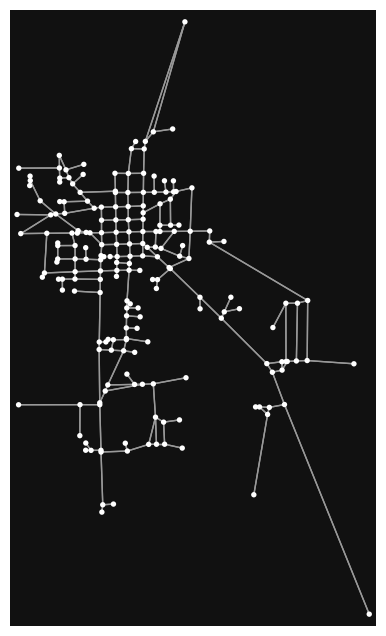

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [24]:
ox.plot_graph(G0)

In [25]:
def remove_duplicate_edges(graph_with_duplicates, print_exclusions=False):
    """ 
    Returns a new, plottable, networkx MultiDiGraph with duplicate edges removed.
    I.e., if for nodes u and v there are multiple edges (u,v) or (v,u) in the 
    original graph, the new graph only has one such edge.

    Adds all attributes and keys from the original edges to the new graph
    
    Also adds the "crs" attribute to the new graph so it can be plotted
    using OSMnx

    Paramters
    ---------
    graph_with_duplicates : networkx.MultiDiGraph
    
    print_exclusions : boolean, default False
    If set to True, prints out the nodes of an edge whenever excluded
    
    Returns
    -------
    graph_new : networkx.MultiDiGraph
    """
    graph_new = nx.MultiDiGraph()

    # Copy nodes and their attributes
    graph_new.add_nodes_from(graph_with_duplicates.nodes(data=True))

    # Iterate through edges and, if they're not duplicates, add them to the new graph
    included_edges = set()
    for u, v, edge_key, data in graph_with_duplicates.edges(keys=True, data=True):
        if (u,v) not in included_edges and (v,u) not in included_edges:
            graph_new.add_edge(u,v,edge_key,**data)
            included_edges.add((u,v))
        elif print_exclusions: 
            print(f"Duplicate edge {(u,v)} excluded")
        
    graph_new.graph["crs"] = graph_with_duplicates.graph["crs"]
    
    return graph_new


In [26]:
G = remove_duplicate_edges(G0, print_exclusions=False)

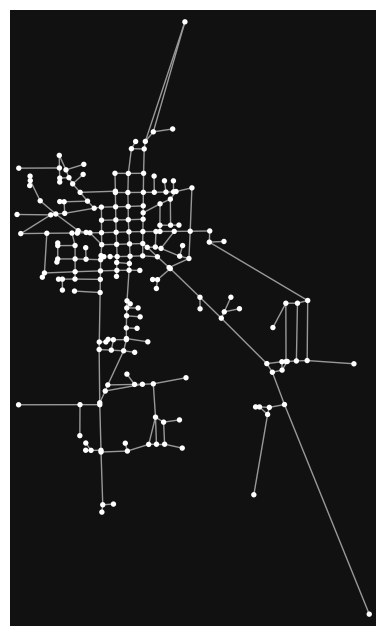

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [27]:
ox.plot_graph(G)

In [8]:
source_nodes, treatment_nodes = source_treatment(G0)

In [9]:
def load_decision_variables(periods):
    """ 
    Loads the dictionaries containing the values of the decision variables 
    from files created by the modeling code. Each dictionary is loaded 
    into a dictionary indexed by period. It is assumed that the files 
    are of the format `<variable name>_sol_period_<period index>` where
    `<variable name>` is one of x,y,z,a,el,r,q,p,d,c. 
    
    Parameters
    ----------
    periods : iterable
    The values used to index the time period of a particular solution.
    Must match `<period index>` in an existing file or the value at that 
    time period will be `None`

    Returns
    -------
    A tuple of the dictionaries containing the solutions from each period
    in `periods`
    """

    x_sol = {period : None for period in periods}
    y_sol = {period : None for period in periods}
    z_sol = {period : None for period in periods}
    a_sol = {period : None for period in periods}
    el_sol = {period : None for period in periods}
    r_sol = {period : None for period in periods}
    q_sol = {period : None for period in periods}
    p_sol = {period : None for period in periods}
    d_sol = {period : None for period in periods}
    c_sol = {period : None for period in periods}
    
    for period in periods:
        with open(f"solutions\\x_sol_period_{period}.json", "r") as f:
            x_sol[period] = {ast.literal_eval(key): value for key, value in json.load(f).items()}
        with open(f"solutions\\y_sol_period_{period}.json", "r") as f:
            y_sol[period] = {ast.literal_eval(key): value for key, value in json.load(f).items()}
        with open(f"solutions\\z_sol_period_{period}.json", "r") as f:
            z_sol[period] = {ast.literal_eval(key): value for key, value in json.load(f).items()}
        with open(f"solutions\\a_sol_period_{period}.json", "r") as f:
            a_sol[period] = {ast.literal_eval(key): value for key, value in json.load(f).items()}
        with open(f"solutions\\el_sol_period_{period}.json", "r") as f:
            el_sol[period] = {ast.literal_eval(key): value for key, value in json.load(f).items()}
        with open(f"solutions\\r_sol_period_{period}.json", "r") as f:
            r_sol[period] = {ast.literal_eval(key): value for key, value in json.load(f).items()}
        with open(f"solutions\\q_sol_period_{period}.json", "r") as f:
            q_sol[period] = {ast.literal_eval(key): value for key, value in json.load(f).items()}
        with open(f"solutions\\p_sol_period_{period}.json", "r") as f:
            p_sol[period] = {ast.literal_eval(key): value for key, value in json.load(f).items()}
        try:
            with open(f"solutions\\d_sol_period_{period}.json", "r") as f:
                d_sol[period] = {ast.literal_eval(key): value for key, value in json.load(f).items()}
        except FileNotFoundError:
            print(f"File d_sol_period_{period}.json not found.") 
        try:
            with open(f"solutions\\c_sol_period_{period}.json", "r") as f:
                c_sol[period] = {ast.literal_eval(key): value for key, value in json.load(f).items()}
        except FileNotFoundError:
            print(f"File c_sol_period_{period}.json not found.") 
    
    return (x_sol, y_sol, z_sol, a_sol, el_sol, r_sol, q_sol, p_sol, d_sol, c_sol)

In [10]:
(x_sol, y_sol, z_sol, a_sol, el_sol, r_sol, q_sol, p_sol, d_sol, c_sol) = \
    load_decision_variables([0,1])

File d_sol_period_0.json not found.
File c_sol_period_0.json not found.


In [11]:
def which_elements_change(var_a, var_b):
    changed_elements = set()
    for key in var_a.keys():
        if var_a[key] != var_b[key]:
            changed_elements.add(key)
    return changed_elements

In [12]:
edges_changed = which_elements_change(z_sol[0], z_sol[1])
nodes_changed_list = []
for edge in edges_changed:
    nodes_changed_list.extend(edge)
nodes_changed_set = set(nodes_changed_list)

In [13]:
def generate_hex_colors(n, cmap_name='hsv'):
    cmap = plt.get_cmap(cmap_name)
    colors = [mcolors.to_hex(cmap(i / (n - 1))) for i in range(n)]
    return colors

In [14]:
generate_hex_colors(5, cmap_name='hsv')

['#ff0000', '#84ff00', '#00fff6', '#7200ff', '#ff0018']

In [15]:
ox.plot.get_colors(5, cmap='hsv')

[(1.0, 0.0, 0.0, 1.0),
 (0.5176455764691059, 1.0, 0.0, 1.0),
 (0.0, 1.0, 0.9647031631761764, 1.0),
 (0.44705736433677606, 0.0, 1.0, 1.0),
 (1.0, 0.0, 0.09375, 1.0)]

In [ ]:
def plot_pipe_network(graph, treatment_nodes, source_nodes, y, z, 
                      x=None, color_treatment_nodes=False, highlighted_nodes=None, 
                      highlighted_edges=None, 
                      edge_width=2, cmap_name="rainbow", fig_size=15):
    """ 
    Plots a pipe network with special colors for used/unused treatment nodes and selected edges.
    """
    selected_treatment_centers = [node for node in treatment_nodes if y[node] == 1]
    if color_treatment_nodes:
        treatment_center_colors = {center : color 
                                   for center, color in zip(selected_treatment_centers, 
                                                            generate_hex_colors(len(selected_treatment_centers), 
                                                                               cmap_name=cmap_name))}
    node_colors = []
    for node in graph.nodes:
        if highlighted_nodes is not None and node in highlighted_nodes:
            node_colors.append("yellow")
        elif node in treatment_nodes:
            if y[node] == 1: # Node is a treatment node and is selected by model
                if color_treatment_nodes:
                    node_colors.append(treatment_center_colors[node]) 
                else:
                    node_colors.append("#3366CC")
            else:
                node_colors.append("#404040") # Node is a treatment node but was not selected
        elif node in source_nodes:
            node_colors.append("#336699") # A neutral blue color
        else: 
            node_colors.append("magenta") # Uh-oh! All nodes should be either a treatment node or a source node.

    if x is not None:
        node_path_assignment = {treatment_node : [] for treatment_node in selected_treatment_centers}
        selected_paths = [path for path in x.keys() if x[path] == 1]
        for (path_start, path_end) in selected_paths:
            for treatment_node in node_path_assignment.keys():
                if path_end == treatment_node:
                    node_path_assignment[treatment_node].append(path_start)

    # OSMnx only plots MultiDiGraphs, so we need to check for arcs going in either direction
    is_selected = lambda edge : z[*edge] == 1 or z[*edge[::-1]] == 1

    edge_colors = []
    for edge in graph.edges(data=False):
        if highlighted_edges is not None \
                and (edge in highlighted_edges or edge[::-1] in highlighted_edges):
            if is_selected(edge): # Edge is in z and is highlighted
                edge_colors.append("#00FF00") # Bright green
            else: # Edge is not in z but is highlighted
                edge_colors.append("#880000") # Dark red
        elif is_selected(edge):
            if x is not None and color_treatment_nodes:
                found_color = False
                for treatment_node, sources in node_path_assignment.items():
                    if not found_color and (edge[0] in sources or edge[0] == treatment_node) \
                            and (edge[1] in sources or edge[1] == treatment_node):
                        edge_colors.append(treatment_center_colors[treatment_node])
                        found_color = True
                if not found_color:
                    edge_colors.append("magenta")
                    print(f"Edge apparently not connected to a treatment center: {edge}")
            else: 
                edge_colors.append("white")
        else:
            edge_colors.append("#101010") # A dark grey color
            
    node_sizes = [50 if node in treatment_nodes else 15 for node in graph.nodes]

    return ox.plot_graph(G, figsize=(fig_size,fig_size), node_color=node_colors, node_size=node_sizes, node_alpha=0.9, edge_color=edge_colors, 
                         edge_linewidth=edge_width, bgcolor="#000000")

c:\Users\gabri\anaconda3\envs\SeniorProject_env1\Lib\site-packages\osmnx\convert.py:381: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  dupes = edges[mask].dropna(subset=["geometry"])
c:\Users\gabri\anaconda3\envs\SeniorProject_env1\Lib\site-packages\osmnx\plot.py:616: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  fig, ax = plot_graph(


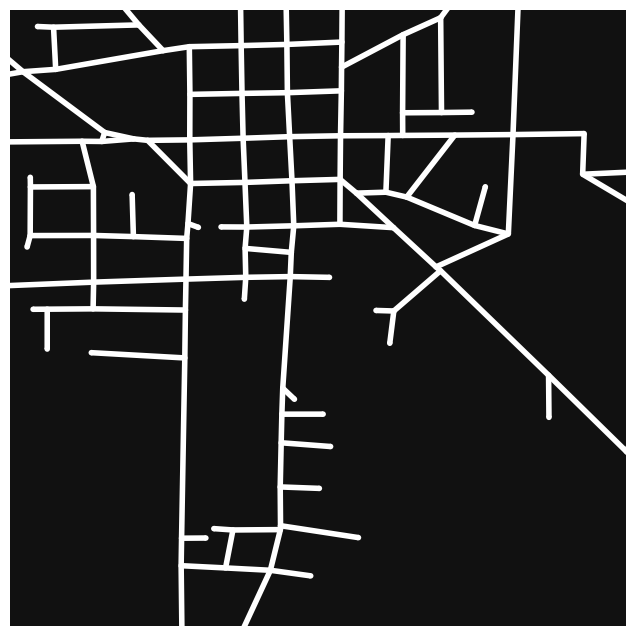

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [17]:
ox.plot_figure_ground(G)

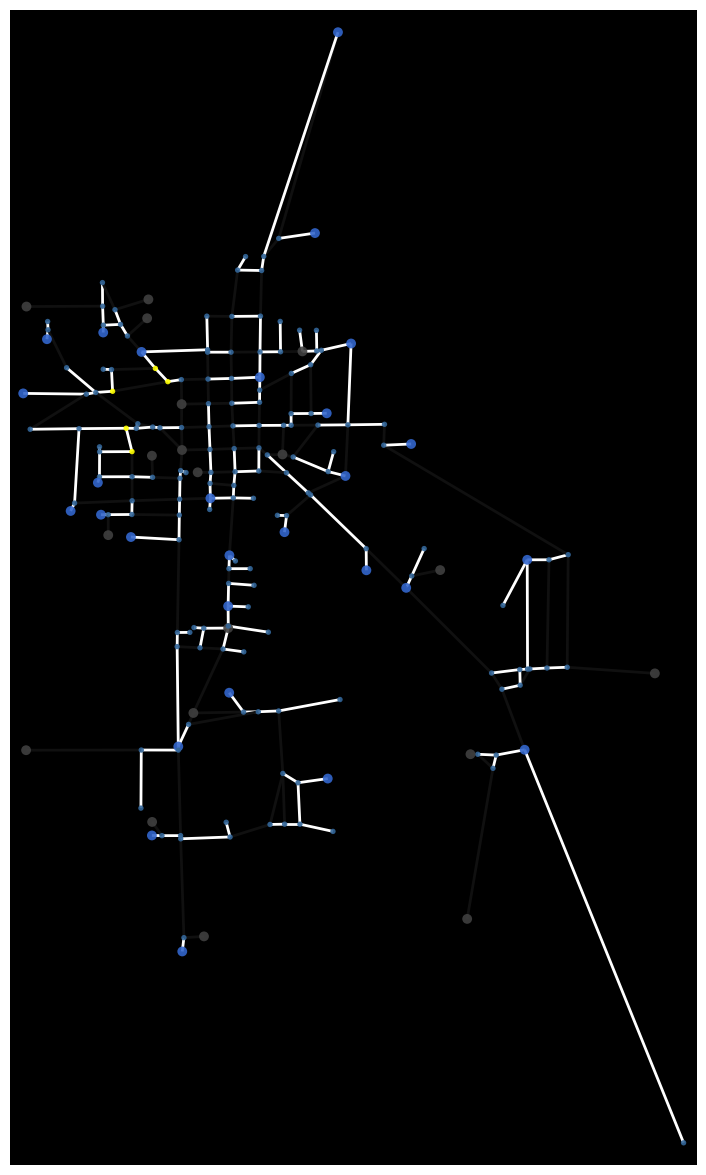

(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

In [18]:
plot_pipe_network(G, treatment_nodes, source_nodes, y_sol[1], z_sol[1], x=x_sol[1], #color_treatment_nodes=True,
                  highlighted_nodes=nodes_changed_set, #highlighted_edges=edges_changed,
                  cmap_name="rainbow")

Edge apparently not connected to a treatment center: (59081605, 59096556)
Edge apparently not connected to a treatment center: (59081605, 59081615)
Edge apparently not connected to a treatment center: (59081605, 59123873)
Edge apparently not connected to a treatment center: (59081615, 59081605)
Edge apparently not connected to a treatment center: (59096556, 59081605)
Edge apparently not connected to a treatment center: (59121412, 59121420)
Edge apparently not connected to a treatment center: (59121412, 59168031)
Edge apparently not connected to a treatment center: (59121420, 59121412)
Edge apparently not connected to a treatment center: (59123873, 59081605)
Edge apparently not connected to a treatment center: (59168031, 59121412)


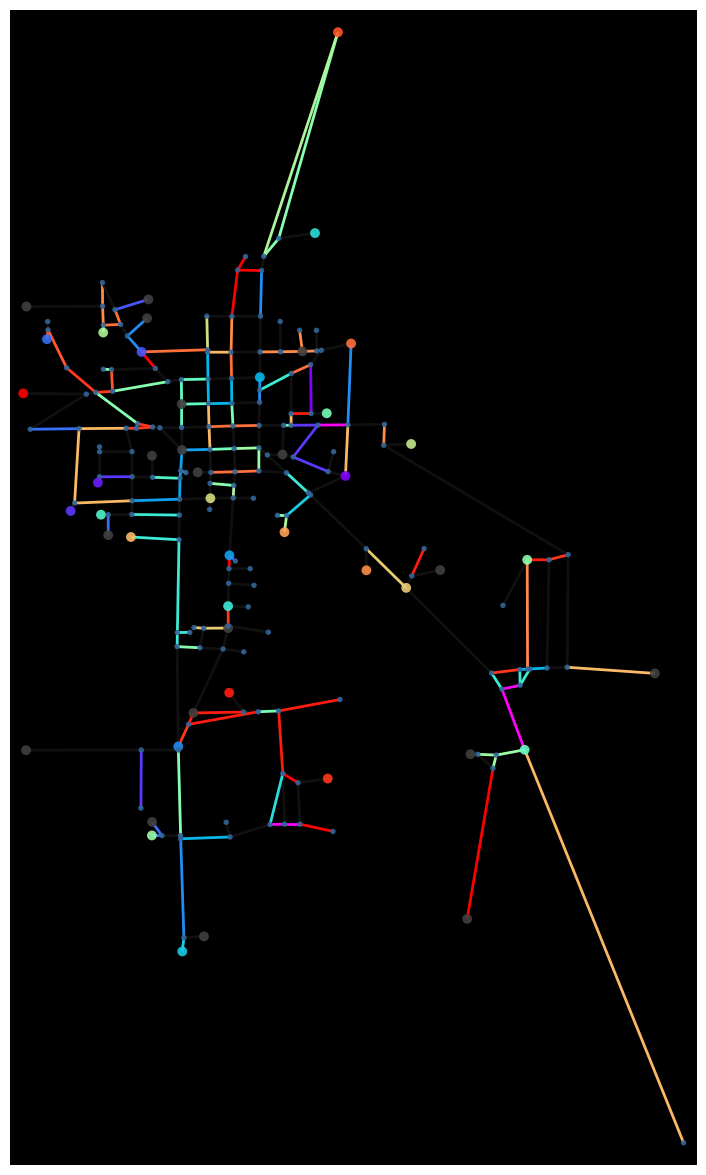

(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

In [21]:
plot_pipe_network(G0, treatment_nodes, source_nodes, y_sol[0], z_sol[0], x=x_sol[0], 
                  color_treatment_nodes=True,
                  #highlighted_nodes=nodes_changed_set, #highlighted_edges=edges_changed, 
                  cmap_name="rainbow")

Edge apparently not connected to a treatment center: (59081605, 59096556)
Edge apparently not connected to a treatment center: (59081605, 59081615)
Edge apparently not connected to a treatment center: (59081605, 59123873)
Edge apparently not connected to a treatment center: (59121412, 59121420)
Edge apparently not connected to a treatment center: (59121412, 59168031)


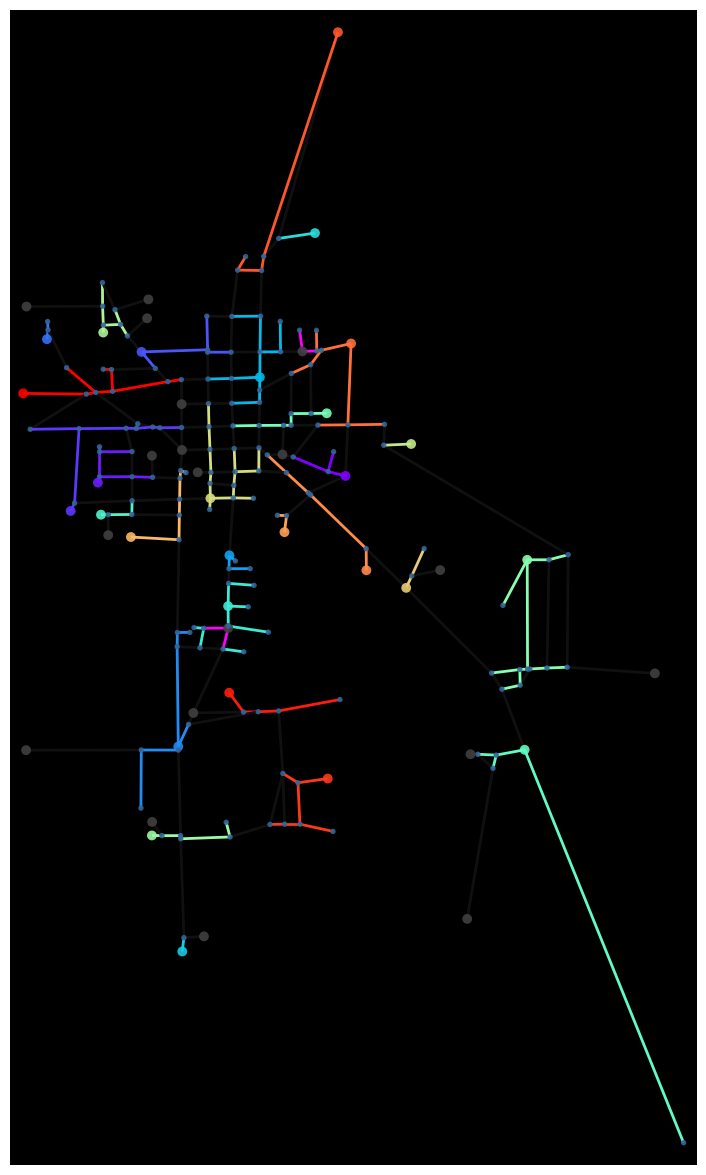

(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

In [19]:
plot_pipe_network(G, treatment_nodes, source_nodes, y_sol[0], z_sol[0], x=x_sol[0], 
                  color_treatment_nodes=True,
                  #highlighted_nodes=nodes_changed_set, #highlighted_edges=edges_changed, 
                  cmap_name="rainbow")

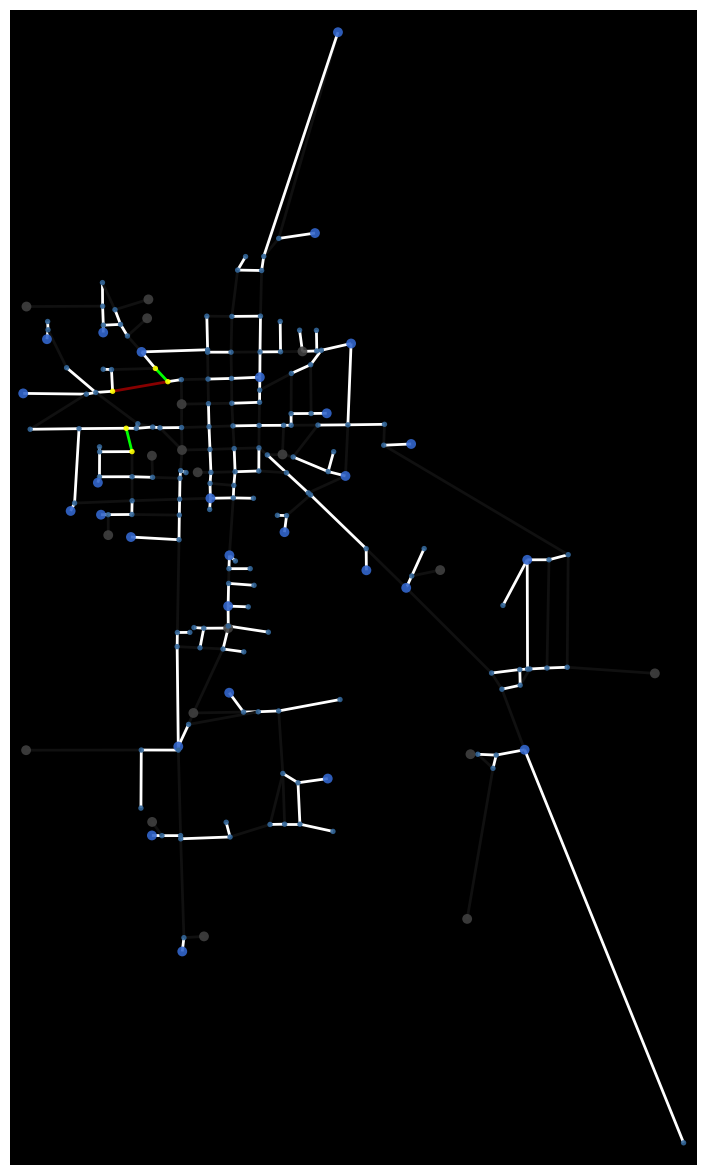

(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

In [20]:
plot_pipe_network(G, treatment_nodes, source_nodes, y_sol[1], z_sol[1], x=x_sol[1], 
                  highlighted_nodes=nodes_changed_set, highlighted_edges=edges_changed, 
                  cmap_name="rainbow")

c:\Users\gabri\anaconda3\envs\SeniorProject_env1\Lib\site-packages\osmnx\convert.py:381: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  dupes = edges[mask].dropna(subset=["geometry"])
c:\Users\gabri\anaconda3\envs\SeniorProject_env1\Lib\site-packages\osmnx\plot.py:616: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  fig, ax = plot_graph(


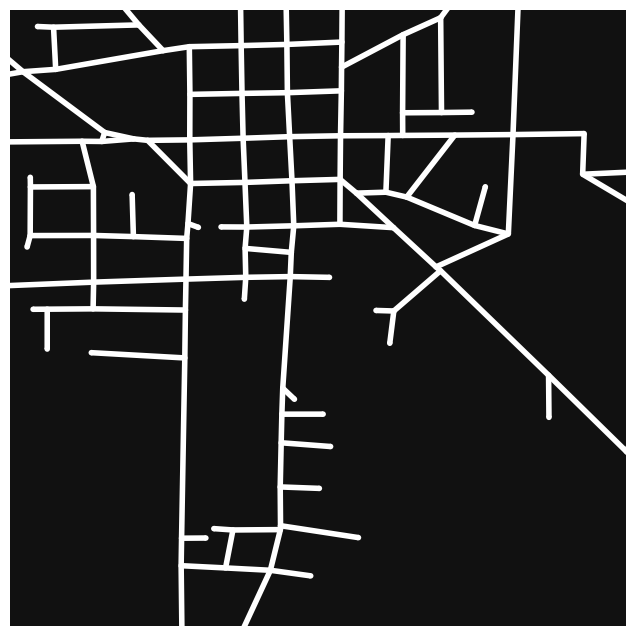

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [69]:
ox.plot_figure_ground(G)

MultiDiGraph with 199 nodes and 506 edges


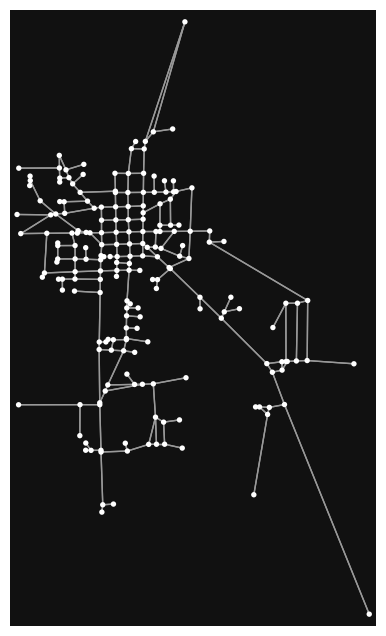

Duplicate edge 5
Duplicate edge 10
Duplicate edge 14
Duplicate edge 16
Duplicate edge 21
Duplicate edge 23
Duplicate edge 30
Duplicate edge 32
Duplicate edge 40
Duplicate edge 46
Duplicate edge 55
Duplicate edge 58
Duplicate edge 60
Duplicate edge 63
Duplicate edge 64
Duplicate edge 65
Duplicate edge 69
Duplicate edge 71
Duplicate edge 75
Duplicate edge 76
Duplicate edge 78
Duplicate edge 80
Duplicate edge 82
Duplicate edge 85
Duplicate edge 88
Duplicate edge 92
Duplicate edge 93
Duplicate edge 94
Duplicate edge 96
Duplicate edge 97
Duplicate edge 100
Duplicate edge 104
Duplicate edge 107
Duplicate edge 110
Duplicate edge 112
Duplicate edge 113
Duplicate edge 114
Duplicate edge 117
Duplicate edge 121
Duplicate edge 125
Duplicate edge 126
Duplicate edge 130
Duplicate edge 133
Duplicate edge 134
Duplicate edge 139
Duplicate edge 140
Duplicate edge 141
Duplicate edge 144
Duplicate edge 147
Duplicate edge 149
Duplicate edge 152
Duplicate edge 158
Duplicate edge 159
Duplicate edge 161
Dupli

In [ ]:
print(G0)
edge_set = set()
for count, (u,v,key) in enumerate(G0.edges(keys=True)):
    if ((u,v) in edge_set) or ((v,u) in edge_set):
        print(f"Duplicate edge {count}")
    else:
        edge_set.add((u,v))

In [5]:
print(G0.edges())

[(59079200, 59103180), (59079983, 59079984), (59079983, 59112334), (59079983, 59106124), (59079984, 59125609), (59079984, 59079983), (59079984, 59125613), (59080764, 59080765), (59080764, 59082984), (59080764, 59084990), (59080765, 59080764), (59080765, 59080775), (59080765, 59095026), (59080775, 59080788), (59080775, 59080765), (59080775, 59107322), (59080788, 59080775), (59080788, 59123873), (59080788, 59095026), (59081555, 59081564), (59081564, 59081566), (59081564, 59081555), (59081564, 59095700), (59081566, 59081564), (59081566, 59112364), (59081566, 59112347), (59081605, 59096556), (59081605, 59081615), (59081605, 59123873), (59081615, 59081625), (59081615, 59081605), (59081615, 59102119), (59081625, 59081615), (59081682, 59084990), (59081682, 59084971), (59081682, 59104191), (59081782, 59081790), (59081782, 59112364), (59081782, 59146293), (59081790, 9930802707), (59081790, 59081782), (59081790, 9930785225), (59081840, 59081845), (59081840, 59123827), (59081840, 59101042), (5908

# Why we get a `crs` attribute error
It's because we're copying some but not all attributes of the OSMnx multidigraph to a fresh multidigraph. Luckily we can just manually set the `"crs"` attribute on the new graph instance.

In [6]:
print(G0.graph)

{'created_date': '2025-01-23 19:48:42', 'created_with': 'OSMnx 1.9.4', 'crs': 'epsg:4326', 'simplified': True}


In [10]:
G0.graph["crs"]
G.graph["crs"]

'epsg:4326'

In [12]:
with open("solutions\\y_sol_period_0.json", "r") as f:
    y_sol_0 = {ast.literal_eval(key): value for key, value in json.load(f).items()}

with open("solutions\\z_sol_period_0.json", "r") as f:
    z_sol_0 = {ast.literal_eval(key): value for key, value in json.load(f).items()}

with open("solutions\\y_sol_period_1.json", "r") as f:
    y_sol_1 = {ast.literal_eval(key): value for key, value in json.load(f).items()}

with open("solutions\\z_sol_period_1.json", "r") as f:
    z_sol_1 = {ast.literal_eval(key): value for key, value in json.load(f).items()}

In [13]:
with open("solutions\\x_sol_period_0.json", "r") as f:
    x_sol_0 = {ast.literal_eval(key): value for key, value in json.load(f).items()}

with open("solutions\\x_sol_period_1.json", "r") as f:
    x_sol_1 = {ast.literal_eval(key): value for key, value in json.load(f).items()}

In [17]:
x_sol[0]

{(59079984, 59128065): 0.0,
 (59079984, 59133314): 0.0,
 (59079984, 59116291): 0.0,
 (59079984, 59121412): 0.0,
 (59079984, 59081605): 0.0,
 (59079984, 59126150): 0.0,
 (59079984, 59133192): 0.0,
 (59079984, 59117577): 0.0,
 (59079984, 59091084): 0.0,
 (59079984, 59123853): 0.0,
 (59079984, 59110286): 0.0,
 (59079984, 59116300): 0.0,
 (59079984, 59129101): 0.0,
 (59079984, 59146899): 0.0,
 (59079984, 59095700): 0.0,
 (59079984, 59124248): 0.0,
 (59079984, 59096602): 0.0,
 (59079984, 59110431): 0.0,
 (59079984, 59079200): 0.0,
 (59079984, 3584201894): 0.0,
 (59079984, 4231830135): 0.0,
 (59079984, 59123881): 0.0,
 (59079984, 59101100): 0.0,
 (59079984, 59079983): 0.0,
 (59079984, 59090484): 0.0,
 (59079984, 59146293): 0.0,
 (59079984, 59129525): 1.0,
 (59079984, 59118652): 0.0,
 (59079984, 59103172): 0.0,
 (59079984, 59101385): 0.0,
 (59079984, 59146313): 0.0,
 (59079984, 59110347): 0.0,
 (59079984, 59158864): 0.0,
 (59079984, 59133777): 0.0,
 (59079984, 59146231): 0.0,
 (59079984, 5908

In [ ]:
selected_paths = [path for path in x_sol_0.keys() if x_sol_0[path] == 1]
print(selected_paths)
print(len(selected_paths))

[(59079984, 59129525), (59080764, 59107322), (59080765, 59107322), (59080775, 59107322), (59081555, 59081566), (59081564, 59081566), (59081615, 59123881), (59081625, 59123881), (59081682, 4230838774), (59081782, 59118652), (59081790, 59118652), (59081840, 59097341), (59081845, 59097341), (59082151, 4231830135), (59082376, 59153773), (59082984, 59107322), (59084971, 4230838774), (59084975, 4230838774), (59084990, 4230838774), (59091067, 59091084), (59091076, 59091084), (59094292, 59118652), (59095026, 59123853), (59095757, 59126150), (59095758, 59126150), (59096556, 59123881), (59096570, 59123881), (59096600, 59133314), (59097709, 59126150), (59101042, 59097341), (59101386, 59101385), (59101390, 59101385), (59102119, 59123881), (59103180, 59079200), (59104191, 4230838774), (59105503, 59123853), (59105510, 59123853), (59106124, 59128065), (59106145, 59115372), (59108226, 59123853), (59108232, 59123853), (59108749, 59123881), (59108758, 59123881), (59110213, 59110286), (59110218, 59110286

152

In [ ]:
selected_treatment_centers = [node for node in treatment_nodes if y_sol_0[node] == 1]
node_path_assignment = {treatment_node : [] for treatment_node in selected_treatment_centers}
for (path_start, path_end) in selected_paths:
    for treatment_node in node_path_assignment.keys():
        if path_end == treatment_node:
            node_path_assignment[treatment_node].append(path_start)


In [30]:
node_path_assignment

{59128065: [59106124, 59128069, 59158197],
 59133314: [59096600, 59128098, 59129064, 59129073, 59133318, 59161207],
 59126150: [59095757,
  59095758,
  59097709,
  59116298,
  59125630,
  59125637,
  59125639,
  59125643,
  59126151],
 59133192: [59117099, 59123932, 59133189, 59146263, 59146264],
 59091084: [59091067, 59091076],
 59123853: [59095026,
  59105503,
  59105510,
  59108226,
  59108232,
  59145411,
  59145427],
 59110286: [59110213, 59110218, 59110295],
 59146899: [59115377,
  59117103,
  59117109,
  59120062,
  59120066,
  59123924,
  59123928,
  59146259,
  59154485,
  59154488],
 59079200: [59103180],
 4231830135: [59082151],
 59123881: [59081615,
  59081625,
  59096556,
  59096570,
  59102119,
  59108749,
  59108758,
  59123873,
  59123966,
  59168101],
 59090484: [59123240, 59123246, 59126206],
 59146293: [59110359, 59110368, 59127838, 59146308],
 59129525: [59079984, 59115076, 59123919, 59125609, 59125613, 59129518],
 59118652: [59081782,
  59081790,
  59094292,
  5911

In [ ]:
source_per_treatment_center = {center : sources for center, sources in }

In [14]:
z_sol_0

{(59079200, 59103180): 0.0,
 (59079983, 59079984): 0.0,
 (59079983, 59112334): 0.0,
 (59079983, 59106124): 0.0,
 (59079984, 59125609): 1.0,
 (59079984, 59079983): 0.0,
 (59079984, 59125613): 0.0,
 (59080764, 59080765): 1.0,
 (59080764, 59082984): 0.0,
 (59080764, 59084990): 0.0,
 (59080765, 59080764): 0.0,
 (59080765, 59080775): 1.0,
 (59080765, 59095026): 0.0,
 (59080775, 59080788): 0.0,
 (59080775, 59080765): 0.0,
 (59080775, 59107322): 1.0,
 (59080788, 59080775): 0.0,
 (59080788, 59123873): 0.0,
 (59080788, 59095026): 0.0,
 (59081555, 59081564): 1.0,
 (59081564, 59081566): 1.0,
 (59081564, 59081555): 0.0,
 (59081564, 59095700): 0.0,
 (59081566, 59081564): 0.0,
 (59081566, 59112364): 0.0,
 (59081566, 59112347): 0.0,
 (59081605, 59096556): 1.0,
 (59081605, 59081615): 0.0,
 (59081605, 59123873): 0.0,
 (59081615, 59081625): 0.0,
 (59081615, 59081605): 1.0,
 (59081615, 59102119): 0.0,
 (59081625, 59081615): 1.0,
 (59081682, 59084990): 0.0,
 (59081682, 59084971): 1.0,
 (59081682, 59104191

In [36]:
print([z_sol_0[edge] for edge in edges_changed])
print(edges_changed[2])

[0.0, 0.0, 1.0]


TypeError: 'set' object is not subscriptable

In [17]:
edges_changed[2]

(59133185, 59123827)

In [18]:
edges_changed[2][::-1]

(59123827, 59133185)

In [37]:
print([z_sol_1[edge] for edge in edges_changed])

[1.0, 1.0, 0.0]


In [28]:
(59123827, 59133185) in list(G.edges(keys=False, data=False))

True

In [ ]:
G_directed_graph = ox.convert.to_digraph(G0)
G_to_plot = nx.MultiDiGraph()
G_to_plot.add_nodes_from(G_directed_graph.nodes)
G_to_plot.add_edges_from(G_directed_graph.edges.data())
ox.plot_graph(G_to_plot)

In [ ]:
G_directed_graph.graph["crs"]

In [ ]:
ox.plot_graph(G_directed_graph)

In [ ]:
G_proj = ox.project_graph(G)

In [ ]:
G_proj.graph["crs"]

In [ ]:
print(y_sol_1)
print(G.graph)
print(z_sol_1)

In [ ]:
print(G.edges(data=False))

In [ ]:
print(z_sol_1[59079200, 59103180])

In [ ]:
G.graph["crs"]

In [ ]:
y_sol